

<div style="text-align: center; color: black; display: inline-block; border-radius: 10px; background-color: #FEDCDC; font-family: Nexa; overflow: hidden; width: 100%; padding: 10px; box-sizing: border-box; margin: 0;">
    <h4>My first Kaggle code share - Your vote would mean the world to me! Thank you❤️</h4>
</div>


In [1]:
import os
import gc
import cv2
import math
import copy
import time
import random
import glob
from torch.cuda.amp import GradScaler, autocast
from matplotlib import pyplot as plt
from PIL import Image

# For data manipulation
import numpy as np
import pandas as pd

# Pytorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp
import torchvision
import torchvision.transforms as transforms

# Utils
import joblib
from tqdm import tqdm
from collections import defaultdict

# Sklearn Imports
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold

# For Image Models
import timm

# Albumentations for augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

# For colored terminal text
from colorama import Fore, Back, Style
b_ = Fore.BLUE
sr_ = Style.RESET_ALL

import warnings
warnings.filterwarnings("ignore")

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import os
import shutil
from torchvision import transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

from datasets import load_dataset
from scipy.signal import find_peaks, savgol_filter
from PIL import Image
import cv2
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms


<div style="color: white; display: inline-block; border-radius: 5px; background-color: #216869; font-family: Nexa; overflow: hidden; width: 100%; padding: 10px; box-sizing: border-box; margin: 0;">
    <h1 style="text-align: center; padding: 0; margin: 0; font-size: 24px; letter-spacing: 0.5px;">Read the Data</h1>
</div>


In [4]:
#CONFIG['T_max'] = df.shape[0] * (CONFIG["n_fold"]-1) * CONFIG['epochs'] // CONFIG['train_batch_size'] // CONFIG["n_fold"]
#CONFIG['T_max']

labels_list = ["HGSC", "MC", "LGSC", "EC", "CC","other"]  # 添加所有标签

encoder = LabelEncoder()
encoder.fit(labels_list)

# 之后，您可以使用以下方式来转换标签：
encoded_labels = encoder.transform(["HGSC", "MC", "LGSC", "EC", "CC","other"])


# 得到resized_mask

In [ ]:
# import os
# import cv2
# import numpy as np
# import random

# output_dir = '/kaggle/working/test_mask'
# if not os.path.exists(output_dir):
#     os.makedirs(output_dir)
# # 假设您已经有了一个DataLoader: loader
# # 假设您的模型已经加载：model

# import os
# from PIL import Image
# import torch
# from tqdm import tqdm

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model_segm.to(device)
# model_segm.eval()
# for batch in tqdm(segm_dataloader):
    
#     thumbnails = batch['thumbnail'].to(device)
#     original_paths = batch['original_path']
#     original_widths = batch['original_width']
#     original_heights = batch['original_height']

#     with torch.no_grad():
#         model_output = model_segm(thumbnails)

#     for i in range(thumbnails.size(0)):
#         mask = (model_output[i, 1, :, :] > 0.7).float()
#         orig_width = original_widths[i]
#         orig_height = original_heights[i]
#         orig_size = (orig_height, orig_width)  # 注意顺序是(height, width)
#         resized_mask = F.interpolate(mask.unsqueeze(0).unsqueeze(0), size=orig_size, mode='bilinear', align_corners=False).squeeze()
      
#         # 从original_paths获取文件名，并添加后缀
#         file_name = os.path.basename(original_paths[i])
#         file_name_without_ext = os.path.splitext(file_name)[0]
#         save_path = os.path.join(output_dir, file_name_without_ext + '_mask.png')

#         # 转换为PIL图像并保存
#         mask_image = Image.fromarray((resized_mask.cpu().numpy() ).astype(np.uint8)).convert('L')
#         mask_image.save(save_path)



# 对分割进行crop_tiles

In [ ]:
# from torchvision.transforms import Normalize
# from torchvision.transforms import ToTensor


  
# def get_random_crop1(original_image, resized_mask_np, box, crop_size, scale_factor, max_attempts=5):
#     x, y, w, h = box
#     transform_normalize = Normalize(mean=[0.82969105, 0.72924012, 0.8340122], std=[0.11099533, 0.15340719, 0.08176311])
#     best_crop = None
#     best_foreground_ratio = 0
   
#     mask_h, mask_w = resized_mask_np.shape

#     for _ in range(max_attempts):
#         # 确保裁剪区域不超过resized_mask_np的边界
#         start_x = min(random.randint(x, x + w), mask_w - crop_size)
#         start_y = min(random.randint(y, y + h), mask_h - crop_size)

#         # 从掩码中裁剪区域
#         mask_crop = resized_mask_np[start_y:start_y + crop_size, start_x:start_x + crop_size]

#         # 计算前景像素的比例
#         foreground_ratio = np.sum(mask_crop) / (crop_size ** 2)

#         # 更新最佳裁剪
#         if foreground_ratio >= best_foreground_ratio:
#             best_foreground_ratio = foreground_ratio
#             best_crop = (start_x, start_y, crop_size, crop_size)
        
#     # 如果找到了满足条件的裁剪区域
#     if best_crop:
#         x, y, _, _ = best_crop
#         orig_start_x = int(x * scale_factor)
#         orig_start_y = int(y * scale_factor)
#         orig_crop_width = int(crop_size * scale_factor)
#         orig_crop_height = int(crop_size * scale_factor)
#         crop_in_orig = (orig_start_x, orig_start_y, orig_crop_width, orig_crop_height)
#         # ... [裁剪和处理图像的代码] ...
#         cropped_image = original_image.crop((orig_start_x, orig_start_y, orig_start_x + orig_crop_width, orig_start_y + orig_crop_height))
#         cropped_image = cropped_image.resize((512, 512), Image.ANTIALIAS)

#         # 将PIL图像转换为张量并标准化
#         cropped_image = transform_normalize(ToTensor()(cropped_image))
#         return cropped_image, crop_in_orig

#     return None, None
    

In [ ]:

# import cv2
# import numpy as np

# def get_largest_bounding_boxes(resized_mask_np, top_k=3):
#     # Find contours from the binary mask
#     contours, _ = cv2.findContours(resized_mask_np, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

#     # Calculate the area of a bounding box
#     def bounding_box_area(box):
#         _, _, w, h = box
#         return w * h

#     # Get bounding boxes of the contours and sort them by area in descending order
#     bounding_boxes = [cv2.boundingRect(cnt) for cnt in contours]
#     bounding_boxes.sort(key=bounding_box_area, reverse=True)

#     # Select the top_k largest bounding boxes
#     largest_bounding_boxes = bounding_boxes[:top_k]

#     # Get the dimensions of the mask
#     mask_h, mask_w = resized_mask_np.shape

#     # If there are less than top_k bounding boxes, duplicate the largest one
#     while len(largest_bounding_boxes) < top_k:
#         if largest_bounding_boxes:
#             largest_bounding_boxes.append(largest_bounding_boxes[0])
#         else:
#             # Placeholder for empty box with the full size of the mask
#             largest_bounding_boxes.append((0, 0, mask_w, mask_h))

#     return largest_bounding_boxes


<div style="color: white; display: inline-block; border-radius: 5px; background-color: #216869; font-family: Nexa; overflow: hidden; width: 100%; padding: 10px; box-sizing: border-box; margin: 0;">
    <h1 style="text-align: center; padding: 0; margin: 0; font-size: 24px; letter-spacing: 0.5px;">Create Model</h1>
</div>


# 展示一个batch

# 原先的用于分割后进行获取crops的dataset

In [ ]:
# import torch
# from torch.utils.data import Dataset
# import cv2
# import numpy as np
# import large_image
# from PIL import Image
# # 解除Pillow的像素限制
# Image.MAX_IMAGE_PIXELS = None
# import matplotlib.pyplot as plt
# from torchvision.transforms.functional import to_pil_image
# # 现在您可以打开
# import numpy as np
# import os
# from torch.utils.data import Dataset
# excluded_files= []
# class SegmentationCropsDataset(Dataset):
#     def __init__(self, image_dir, mask_dir, excluded_files,get_largest_bounding_boxes,get_random_crop1,crop_sizes=(2000, 1500, 1750), final_size=512, threshold=0.5):
#         self.image_dir = image_dir
#         self.mask_dir = mask_dir
#         self.crop_sizes = crop_sizes
#         self.final_size = final_size
#         self.threshold = threshold
#         self.images = []
#         self.masks = []
#         self.get_largest_bounding_boxes = get_largest_bounding_boxes
#         self.get_random_crop =get_random_crop1
#       #  self.large_images = large_images
#         for f in os.listdir(image_dir):
#             if f in excluded_files:  # 跳过排除的文件
#                 continue
#             image_path = os.path.join(image_dir, f)
#             img = Image.open(image_path)
#             if max(img.size) >= 6000:  # 过滤尺寸小于6000像素的图像
#                 if max(img.size) > 40000:  # 过滤尺寸大于40000像素的图像
                    
#                    # large_images.append(os.path.basename(image_path))
#                     img.close()
#                     continue
#                 self.images.append(image_path)
#                 self.masks.append(os.path.join(mask_dir, f.replace('.png', '_mask.png')))
#             img.close()
            
#     def __len__(self):
#         return len(self.images)

#     def __getitem__(self, idx):
#         image_path = self.images[idx]
#         mask_path = self.masks[idx]
#         basename = os.path.basename(image_path)
#         resized_mask = Image.open(mask_path)
#         # Load the original image and mask
#         original_image = Image.open(image_path).convert('RGB')
#         resized_mask_np = np.array(Image.open(mask_path))

#         # Calculate scale factor 'a' from resized mask to original image
#         a_w = original_image.width / resized_mask_np.shape[1]
#         a_h = original_image.height / resized_mask_np.shape[0]
#         a = (a_w + a_h) / 2  # Average scale factor for width and height
#         orig_width, orig_height = original_image.size

#         # Mask dimensions
#         mask_width, mask_height = resized_mask.size
#         # Get bounding boxes of the top 3 largest regions in the mask
#         # Get bounding boxes and scale them for the original image
#         bounding_boxes = self.get_largest_bounding_boxes(resized_mask_np, top_k=3)
#         bounding_boxes_orig = [(x * a_w, y * a_h, w * a_w, h * a_h) for x, y, w, h in bounding_boxes]

#         # Collect crops and their corresponding coordinates on the original image
#         crop_coords_orig = []
#         crops = []
#         for box in bounding_boxes:
#             for size in self.crop_sizes:
#                 scaled_size = int(size / a)
#                 crop, crop_coord = self.get_random_crop(original_image, resized_mask_np, box, scaled_size, a, max_attempts=5)
#                 if crop is not None:
#                     crops.append(crop)
#                     crop_coords_orig.append(crop_coord)

#         # Stack crops if not empty
#         if crops:
#             crops = torch.stack(crops)
#         else:
#             crops = None
#         original_image.close
       

#         return crops, basename
# #         return crops, bounding_boxes, bounding_boxes_orig, crop_coords_orig, image_path, mask_path, resized_mask_np
#     # ... include the implementations of get_random_crop and get_top_bounding_boxes ...

# # 指定图像和掩码的目录路径
# image_directory = '/kaggle/input/UBC-OCEAN/test_images'  # 替换为实际图像目录的路径
# mask_directory = '/kaggle/working/test_mask'   # 替换为实际掩码目录的路径

# # 创建数据集实例
# dataset = SegmentationCropsDataset(image_directory, mask_directory,excluded_files,get_largest_bounding_boxes,get_random_crop1)
# infer_dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=3)
# #print(large_images)

# 展示crops九张图片以及对应路径

In [ ]:
# import matplotlib.pyplot as plt
# import torch
# from torchvision.transforms.functional import to_pil_image

# batch = next(iter(infer_dataloader))
# crops, basename, image_path, mask_path, mask_width, mask_height, orig_width, orig_height = batch

# # 打印路径和大小信息
# print("Image Path:", image_path)
# print("Mask Path:", mask_path)
# print("Mask Size:", (mask_width, mask_height))
# print("Original Image Size:", (orig_width, orig_height))
# def unnormalize(tensor, mean, std):
#     """
#     反归一化张量图像。
#     """
#     for t, m, s in zip(tensor, mean, std):
#         t.mul_(s).add_(m)  # 反归一化
#     return tensor

# # 定义归一化参数
# mean = [0.82969105, 0.72924012, 0.8340122]
# std = [0.11099533, 0.15340719, 0.08176311]

# # 移除批次维度
# crops = crops.squeeze()

# # 展示 crops 图像
# if crops is not None and len(crops.shape) == 4:  # 确认 crops 的维度为 [批次大小, 通道数, 高, 宽]
#     num_crops = crops.shape[0]  # 裁剪图像的数量
#     fig, axs = plt.subplots(num_crops, 1, figsize=(6, 6 * num_crops))  # 设置为一列多行

#     for i in range(num_crops):
#         # 反归一化
#         unnormalized_crop = unnormalize(crops[i], mean, std)
#         crop_img = to_pil_image(unnormalized_crop)
#         axs[i].imshow(crop_img)
#         axs[i].axis('off')

#     plt.show()
# else:
#     print("No crops to display.")

# 展示原图上的框和mask上的框

/kaggle/input/UBC-OCEAN/train_images/22489.png
Box 0: x=tensor([303]), y=tensor([1503]), width=tensor([1064]), height=tensor([857])
Box 1: x=tensor([1326]), y=tensor([684]), width=tensor([621]), height=tensor([718])
Box 2: x=tensor([303]), y=tensor([1503]), width=tensor([1064]), height=tensor([857])


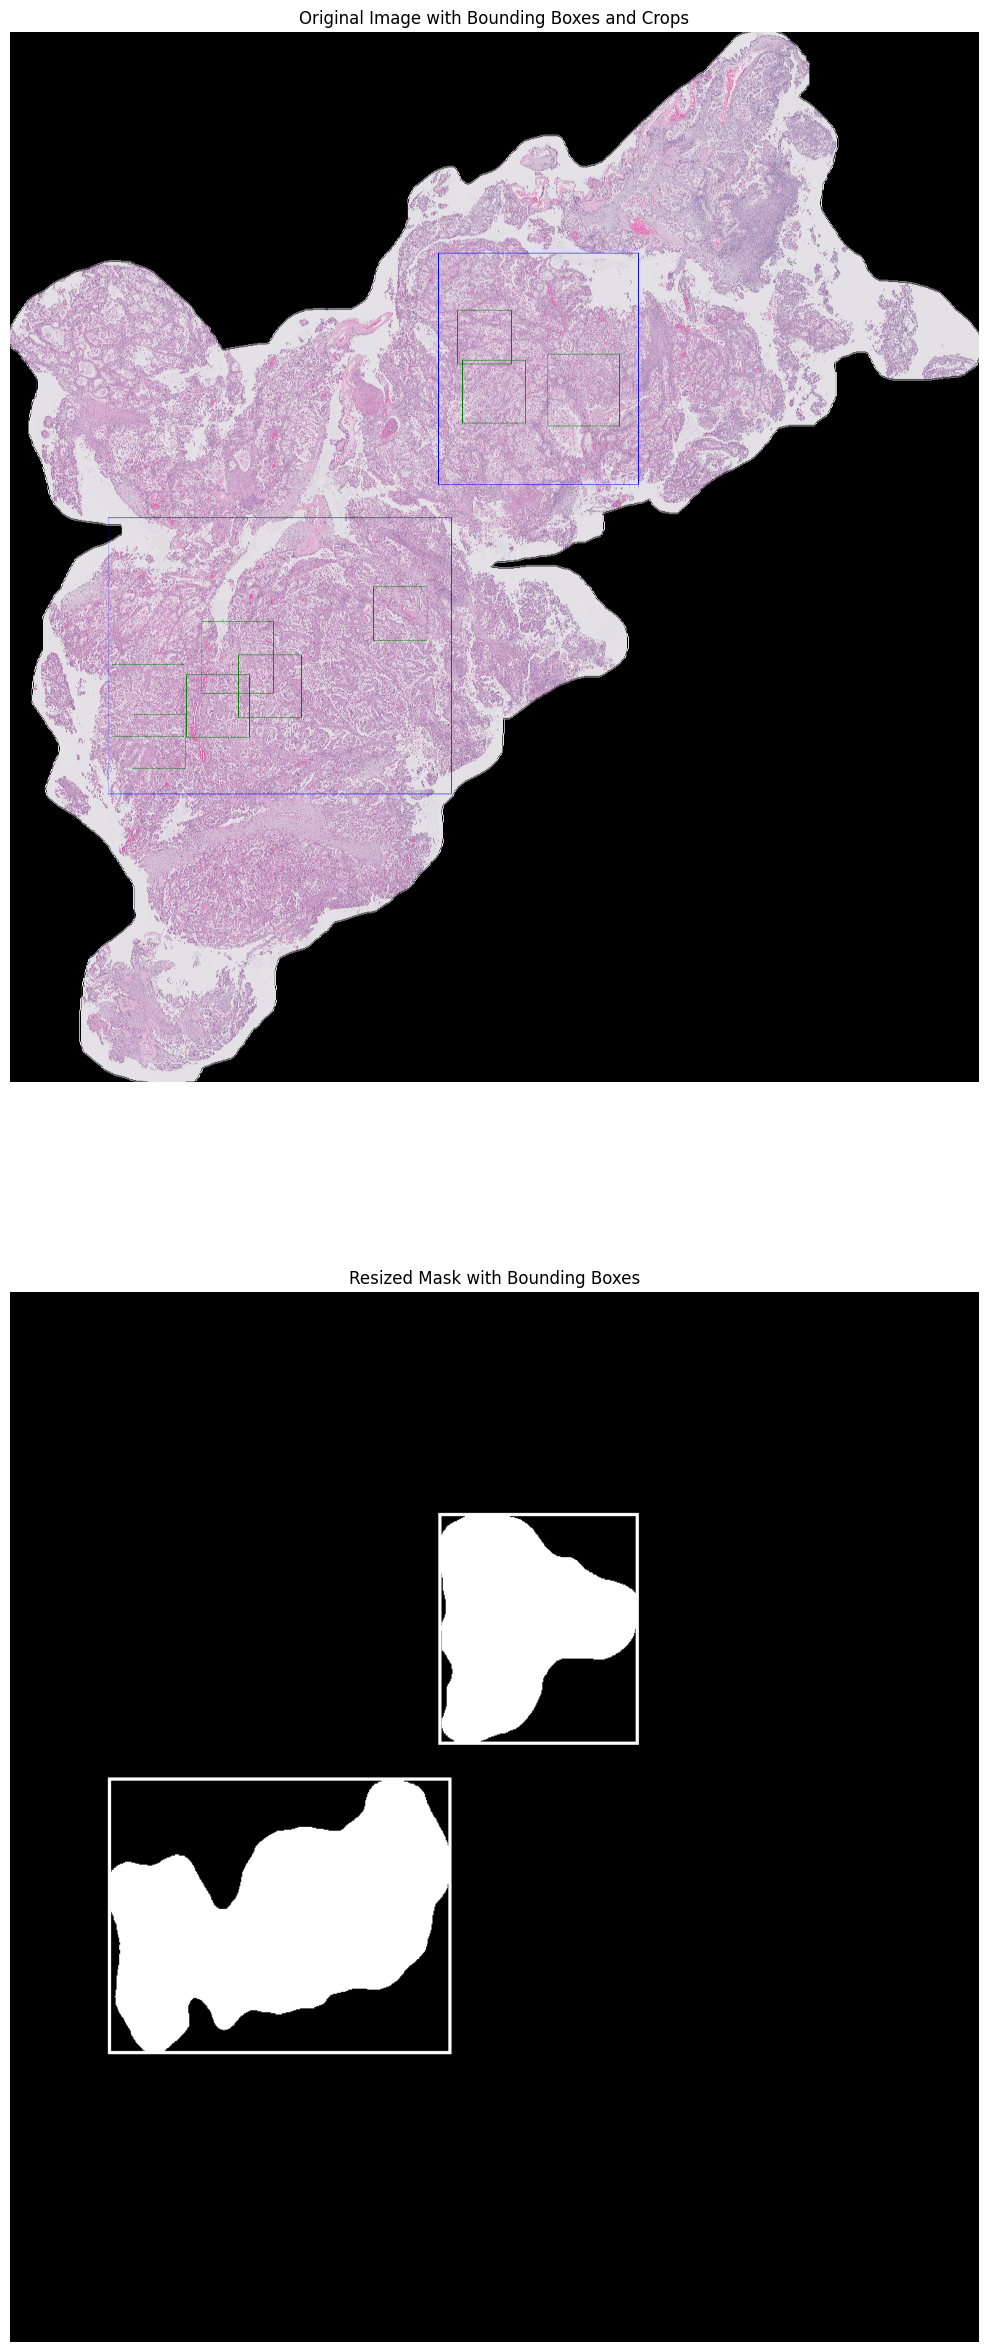

In [22]:
# import matplotlib.pyplot as plt
# from PIL import ImageDraw
# from torchvision.transforms import ToPILImage

# def draw_boxes(image, boxes, color='blue', width=15):
#     draw = ImageDraw.Draw(image)
#     for box in boxes:
#         draw.rectangle([(box[0], box[1]), (box[0] + box[2], box[1] + box[3])], outline=color, width=width)
#     return image
# def draw_boxes_np(image, boxes, color=1, thickness=2):
#     for box in boxes:
#         start_x, start_y, box_w, box_h = [int(coord) for coord in box]
#         end_x, end_y = start_x + box_w, start_y + box_h

#         # 绘制矩形框的四条边
#         image[start_y:end_y, start_x:start_x+thickness] = color  # 左边
#         image[start_y:end_y, end_x-thickness:end_x] = color  # 右边
#         image[start_y:start_y+thickness, start_x:end_x] = color  # 上边
#         image[end_y-thickness:end_y, start_x:end_x] = color  # 下边

#     return image
# # 从 DataLoader 中获取数据
# data_iter = iter(infer_dataloader)
# batch = next(data_iter)
# crops, bounding_boxes, bounding_boxes_orig, crop_coords_orig, image_path, mask_path, resized_mask_np = batch
# print (image_path[0])
# original_image = Image.open(image_path[0]).convert('RGB')
# # 绘制 bounding boxes 和 crops
# # 假设 bounding_boxes 是您从 DataLoader 中获取的
# # 假设 bounding_boxes 是您从 DataLoader 中获取的
# for i, box in enumerate(bounding_boxes):
#     print(f"Box {i}: x={box[0]}, y={box[1]}, width={box[2]}, height={box[3]}")

# resized_mask_np = resized_mask_np.squeeze()
# resized_mask_np = draw_boxes_np(resized_mask_np, bounding_boxes, color=1, thickness=10)
# original_image = draw_boxes(original_image, bounding_boxes_orig, color='blue', width=15)
# original_image = draw_boxes(original_image, crop_coords_orig, color='green', width=15)
# # 展示图像

# plt.figure(figsize=(15, 30))

# # 展示原始图像
# plt.subplot(2, 1, 1)
# plt.imshow(original_image)
# plt.title('Original Image with Bounding Boxes and Crops')
# plt.axis('off')

# # 展示二值掩码图像
# plt.subplot(2, 1, 2)
# plt.imshow(resized_mask_np, cmap='gray')  # 使用灰度颜色映射
# plt.title('Resized Mask with Bounding Boxes')
# plt.axis('off')

# plt.show()



# large的dataset

In [ ]:
large_images = [] 
class SegmentationCropsDataset_large(Dataset):
    def __init__(self, image_dir, mask_dir, excluded_files, large_images,get_largest_bounding_boxes,get_random_crop1,crop_sizes=(2000, 1500, 1750), final_size=1024, threshold=0.5):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.crop_sizes = crop_sizes
        self.final_size = final_size
        self.threshold = threshold
        self.images = []
        self.masks = []
        self.get_largest_bounding_boxes = get_largest_bounding_boxes
        self.get_random_crop1 =get_random_crop1
        self.large_images = large_images
        
        for f in os.listdir(image_dir):
            if f  not in excluded_files:  # 跳过排除的文件
                continue
            image_path = os.path.join(image_dir, f)
            img = Image.open(image_path)
            if max(img.size) >= 6000:  # 过滤尺寸小于6000像素的图像
                if max(img.size) > 40000 and max(img.size) < 60000:  # 过滤尺寸大于40000像素的图像
                    
                    large_images.append(os.path.basename(image_path))
                    img.close()
                    continue
                self.images.append(image_path)
                self.masks.append(os.path.join(mask_dir, f.replace('.png', '_mask.png')))
            img.close()
            
            
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        mask_path = self.masks[idx]
        basename = os.path.basename(image_path)

        # Load the original image and mask
        original_image = Image.open(image_path).convert('RGB')
        resized_mask_np = np.array(Image.open(mask_path))

        # Calculate scale factor 'a' from resized mask to original image
        a_w = original_image.width / resized_mask_np.shape[1]
        a_h = original_image.height / resized_mask_np.shape[0]
        a = (a_w + a_h) / 2  # Average scale factor for width and height

        # Get bounding boxes of the top 3 largest regions in the mask
        bounding_boxes = self.get_largest_bounding_boxes(resized_mask_np, top_k=3)
        
        # Collect crops
        crops = []
        for box in bounding_boxes:
            for size in self.crop_sizes:
                scaled_size = int(size / a)  # Adjust size based on the scale factor
                crop = self.get_random_crop1(original_image, resized_mask_np, box, scaled_size, a, max_attempts=5)
                if crop is not None:
                    crops.append(crop)

        # 使用 torch.stack 在批次维度上堆叠张量
        if crops:
            crops = torch.stack(crops)
        else:
            crops = None

        return crops, basename

    # ... include the implementations of get_random_crop and get_top_bounding_boxes ...

# 指定图像和掩码的目录路径
image_directory = '/kaggle/input/UBC-OCEAN/test_images'  # 替换为实际图像目录的路径
mask_directory = '/kaggle/working/test_mask'   # 替换为实际掩码目录的路径

# 创建数据集实例
dataset_large = SegmentationCropsDataset_large(image_directory, mask_directory,excluded_files,large_images,get_largest_bounding_boxes,get_random_crop1)
infer_dataloader_large = DataLoader(dataset_large, batch_size=1, shuffle=False, num_workers=2)

In [ ]:
class SegmentationCropsDataset_large2(Dataset):
    def __init__(self, image_dir, mask_dir, get_largest_bounding_boxes, get_random_crop1, crop_sizes=(2000, 1500, 1750), final_size=512, threshold=0.5):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.crop_sizes = crop_sizes
        self.final_size = final_size
        self.threshold = threshold
        self.images = []
        self.masks = []
        self.get_largest_bounding_boxes = get_largest_bounding_boxes
        self.get_random_crop = get_random_crop1

        for f in os.listdir(image_dir):
            if f.endswith('.png'):  # 跳过排除的文件，并检查是否为PNG文件
                image_path = os.path.join(image_dir, f)
                with Image.open(image_path) as img:
                    if max(img.size) >= 60000:  # 保留尺寸大于等于60000像素的图像
                        self.images.append(image_path)
                        mask_path = os.path.join(mask_dir, f.replace('.png', '_mask.png'))
                        self.masks.append(mask_path)
                    
                        
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        mask_path = self.masks[idx]
        basename = os.path.basename(image_path)

        # Load the original image and mask
        original_image = Image.open(image_path).convert('RGB')
        resized_mask_np = np.array(Image.open(mask_path))

        # Calculate scale factor 'a' from resized mask to original image
        a_w = original_image.width / resized_mask_np.shape[1]
        a_h = original_image.height / resized_mask_np.shape[0]
        a = (a_w + a_h) / 2  # Average scale factor for width and height

        # Get bounding boxes of the top 3 largest regions in the mask
        bounding_boxes = self.get_largest_bounding_boxes(resized_mask_np, top_k=3)
        
        # Collect crops
        crops = []
        for box in bounding_boxes:
            for size in self.crop_sizes:
                scaled_size = int(size / a)  # Adjust size based on the scale factor
                crop = self.get_random_crop1(original_image, resized_mask_np, box, scaled_size, a, max_attempts=5)
                if crop is not None:
                    crops.append(crop)

        # 使用 torch.stack 在批次维度上堆叠张量
        if crops:
            crops = torch.stack(crops)
        else:
            crops = None

        return crops, basename

    # ... include the implementations of get_random_crop and get_top_bounding_boxes ...

# 指定图像和掩码的目录路径
image_directory = '/kaggle/input/UBC-OCEAN/test_images'  # 替换为实际图像目录的路径
mask_directory = '/kaggle/working/test_mask'   # 替换为实际掩码目录的路径

# 创建数据集实例
dataset_large2 = SegmentationCropsDataset_large2(image_directory, mask_directory,get_largest_bounding_boxes,get_random_crop1)
infer_dataloader_large2 = DataLoader(dataset_large2, batch_size=1, shuffle=False, num_workers=1)
    # ... 其他的类方法 ...


# 数据集类for  TMA

In [ ]:

class TestImagesDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = [os.path.join(root_dir, f) for f in os.listdir(root_dir) if self._is_valid_image(f)]

    def _is_valid_image(self, filename):
        if not filename.endswith('.png'):
            return False
        image_path = os.path.join(self.root_dir, filename)
        with Image.open(image_path) as img:
            return max(img.size) < 6000

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        basename = os.path.basename(image_path)
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, basename

transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.82969105, 0.72924012, 0.8340122], std=[0.11099533, 0.15340719, 0.08176311])
])

dataset_TMA = TestImagesDataset(root_dir='/kaggle/input/UBC-OCEAN/test_images', transform=transform)
dataloader_TMA = DataLoader(dataset_TMA, batch_size=20, shuffle=False, num_workers=3)





# 加载efficientnet-b4 + transformer_6layers

In [ ]:
import torch
import torch.nn as nn
import timm
from torch.nn import TransformerEncoder, TransformerEncoderLayer
class CustomEfficientNet(nn.Module):
    def __init__(self, num_classes=6, pretrained=False):
        super(CustomEfficientNet, self).__init__()
        # 加载预训练的 EfficientNet-B4
        self.base_model = timm.create_model('efficientnet_b4', pretrained=pretrained, features_only=True, out_indices=[-1])

        # 创建 Transformer 编码器层，增加层数和前馈网络的维度
        encoder_layer1 = TransformerEncoderLayer(d_model=448, nhead=4, dim_feedforward=512, dropout=0.1)
        self.transformer_encoder1 = TransformerEncoder(encoder_layer1, num_layers=4)
        
        encoder_layer2 = TransformerEncoderLayer(d_model=448, nhead=4, dim_feedforward=512, dropout=0.1)
        self.transformer_encoder2 = TransformerEncoder(encoder_layer2, num_layers=2)

        # 分类器
        self.classifier = nn.Linear(448, num_classes)
        # 分类器
        d_model = 448

        # 位置编码
        self.pos_encoder = PositionalEncoding(d_model)

    def forward(self, x):
        # 通过 EfficientNet 获取特征图
        x = self.base_model(x)[-1]

        # 调整特征图以适应 Transformer
        x = x.permute(0, 2, 3, 1)
        x = x.reshape(x.size(0), -1, x.size(3))
        # 添加位置编码
        x = self.pos_encoder(x)

        # 通过两个 Transformer 编码器
        x = self.transformer_encoder1(x)
        x = self.transformer_encoder2(x)

        # 使用平均池化减少序列维度
        x = x.mean(dim=1)

        # 通过分类器
        return self.classifier(x)

    # def forward(self, x):
    #     # 通过 EfficientNet 获取特征图
    #     x = self.base_model(x)[-1]

    #     # 调整特征图以适应新的序列结构
    #     B, C, H, W = x.shape
    #     x = x.view(B * H * W, C)  # 重塑为 [B * H * W, C]

    #     # 添加位置编码
    #     x = self.pos_encoder(x, B, H, W)

    #     # 通过 Transformer 编码器
    #     x = self.transformer_encoder1(x)
    #     x = self.transformer_encoder2(x)

    #     # 使用全局平均池化来减少序列维度
    #     x = x.mean(dim=0)

    #     # 通过分类器
    #     return self.classifier(x)
# Positional Encoding 类
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=6000):
        super(PositionalEncoding, self).__init__()
        # 创建一个足够长的位置编码
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return x
#     def forward(self, x, B, H, W):
#     jump = H * W  # 定义跳动间隔
#     pos = torch.cat([self.pe[i * jump: (i + 1) * jump] for i in range(B)], dim=0)
#     x = x + pos[:x.size(0), :]
#     return x


model = CustomEfficientNet().to('cuda' if torch.cuda.is_available() else 'cpu')

# 使用 DataParallel 包装模型以支持多 GPU（如果有多个GPU）
# if torch.cuda.device_count() > 1:
#     print(f"[INFO] Using {torch.cuda.device_count()} GPUs!")
#     model = nn.DataParallel(model)

# 直接加载整个模型的预训练权重
pretrained_dict = torch.load('/kaggle/input/cnn-transformer-tma/Acc0.50_CNNtransformer_data_12-25_for_TMA_epoch5.bin')
model.load_state_dict(pretrained_dict)



# 第一版 ，应用阈值 0.7置1，其余都为0

In [14]:

# import torch
# from torch.nn.functional import softmax

# # 指定模型运行的设备
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# df = pd.read_csv('/kaggle/input/UBC-OCEAN/train.csv')
# id_label_dict = dict(zip(df['image_id'], df['label']))
# # 确保模型在正确的设备上
# model = model.to(device)
# model.eval()
# # 假设 model 是您的模型
# model_device = next(model.parameters()).device
# print("Model is on device:", model_device)

# count = 0
# correct_predictions = 0

# with torch.no_grad():
#     for batch in tqdm(infer_dataloader):
#         images, basename = batch
#         image_id = int(basename[0].split('.')[0])
#         actual_label = id_label_dict[image_id]
#         actual_label = encoder.transform([actual_label])[0]

#         images = images.squeeze(0).to(device)
#         logits = model(images)
#         probs = softmax(logits, dim=1)  # Apply softmax to each image's logits

#         # Apply threshold to each image's probabilities and set max class to 1 if confidence > 0.7
#         thresholded_probs = torch.where(probs > 0.7, torch.tensor(1.0, device=device), torch.tensor(0.0, device=device))

#         # Sum the thresholded probabilities from all images in the batch
#         probs_sum = torch.sum(thresholded_probs, dim=0)
#         final_probs = softmax(probs_sum, dim=0)  # Apply softmax to the summed probabilities
#         pred_class = torch.argmax(final_probs).item()
#         count += 1
#         if actual_label == pred_class:
#             correct_predictions += 1

# accuracy = correct_predictions / count
# print("Accuracy:", accuracy)
# # 此时，all_predictions 包含了每个图像的预测类别


Model is on device: cuda:0


100%|██████████| 9/9 [01:39<00:00, 11.08s/it]

Accuracy: 0.3333333333333333


# 第二版 ，应用阈值0.7置1，其余prob不变

In [20]:
# correct_predictions = 0
# count = 0

# with torch.no_grad():
#     for batch in tqdm(infer_dataloader):
#         images, basename = batch
#         image_id = int(basename[0].split('.')[0])
#         actual_label = id_label_dict[image_id]
#         actual_label = encoder.transform([actual_label])[0]

#         images = images.squeeze(0).to(device)
#         logits = model(images)
#         probs = softmax(logits, dim=1)  # Apply softmax to each image's logits

#         # Initialize a tensor to hold the modified probabilities
#         modified_probs = torch.zeros_like(probs)

#         # Loop through each sample's probabilities
#         for i, sample_probs in enumerate(probs):
#             max_prob, max_index = torch.max(sample_probs, dim=0)
#             if max_prob > 0.7:
#                 # Convert to one-hot encoding if maximum probability is greater than 0.7
#                 one_hot = torch.zeros_like(sample_probs)
#                 one_hot[max_index] = 1.0
#                 modified_probs[i] = one_hot
#             else:
#                 # Keep the original probabilities if no class probability exceeds 0.7
#                 modified_probs[i] = sample_probs

#         # Sum the modified probabilities from all samples
#         summed_probs = torch.sum(modified_probs, dim=0)
#         final_probs = softmax(summed_probs, dim=0)  # Apply softmax to the summed probabilities
#         pred_class = torch.argmax(final_probs).item()

#         # Increment the count and correct_predictions
#         count += 1
#         if actual_label == pred_class:
#             correct_predictions += 1

# # Calculate the accuracy
# accuracy = correct_predictions / count if count > 0 else 0
# print(f"Accuracy: {accuracy}")

#  推理提交csv

In [23]:
import torch
from torch.nn.functional import softmax
from tqdm import tqdm
import pandas as pd

def run_inference(model, dataloader, device, encoder):
    """
    对给定的数据加载器进行模型推理
    :param model: 训练好的模型
    :param dataloader: 数据加载器
    :param device: 设备（CPU或GPU）
    :param encoder: 用于将预测类别编号转换为类别名称的编码器
    :return: 预测结果列表和图像ID列表
    """
    model.eval()
    predictions = []
    image_ids = []
    with torch.no_grad():
        for images, basename in tqdm(dataloader):
            images = images.squeeze(0).to(device)  # 删除批次维度
            logits = model(images)  # 获得每个小样本的logits
            summed_logits = torch.sum(logits, dim=0)  # 对所有小样本的logits求和
            probs = softmax(summed_logits.unsqueeze(0), dim=1)  # 应用softmax
            pred_class = torch.argmax(probs, dim=1).item()  # 获取最大概率的类别索引
            pred_label = encoder.inverse_transform([pred_class])[0]  # 将索引转换为类别名称
            predictions.append(pred_label)
            image_ids.append(int(basename[0].split('.')[0]))     # 获取图像ID
    return image_ids, predictions

def create_submission_file(image_ids, predictions, output_file):
    """
    创建提交文件
    :param image_ids: 图像ID列表
    :param predictions: 预测结果列表
    :param output_file: 输出文件名
    """
    df = pd.DataFrame({
        'image_id': image_ids,
        'label': predictions
    })
    df.to_csv(output_file, index=False)

# 模型推理
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 假设encoder已经准备好
# encoder = ...

# 为每个dataloader运行推理
image_ids1, predictions1 = run_inference(model, infer_dataloader, device, encoder)
image_ids2, predictions2 = run_inference(model, infer_dataloader_large, device, encoder)
image_ids3, predictions3 = run_inference(model, infer_dataloader_large2, device, encoder)

# 合并所有结果
all_image_ids = image_ids1 + image_ids2 + image_ids3
all_predictions = predictions1 + predictions2 + predictions3


# 创建提交文件
create_submission_file(all_image_ids, all_predictions, "/kaggle/working/sample_submission.csv")


100%|██████████| 143/143 [34:23<00:00, 14.43s/it]


In [24]:
def run_inference(model, dataloader, device, encoder, output_csv):
    model.eval()
    with torch.no_grad(), open(output_csv, 'a') as file:  # 'a'模式用于追加到文件
        for images, basenames in tqdm(dataloader):
            images = images.to(device)
            logits = model(images)
            probs = torch.softmax(logits, dim=1)
            pred_classes = torch.argmax(probs, dim=1).cpu().numpy()
            pred_labels = encoder.inverse_transform(pred_classes)

            for basename, label in zip(basenames, pred_labels):
                file.write(f"{int(basename.split('.')[0])},{label}\n")

# 运行推理并将结果追加到CSV文件
run_inference(model, dataloader_TMA, device, encoder, "/kaggle/working/sample_submission.csv")


100%|██████████| 2/2 [00:13<00:00,  6.60s/it]


<div style="text-align: center; color: black; display: inline-block; border-radius: 10px; background-color: #FEDCDC; font-family: Nexa; overflow: hidden; width: 100%; padding: 10px; box-sizing: border-box; margin: 0;">
    <h1>My first Kaggle code share - Your vote would mean the world to me! Thank you❤️</h1>
</div>
